In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
train_set = keras.preprocessing.image_dataset_from_directory(
   "C:/Users/user/Downloads/archive/Training",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

test_set = keras.preprocessing.image_dataset_from_directory(
    "C:/Users/user/Downloads/archive/Testing",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [3]:
class_names = train_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
# prompt: get the number of samples in test and train set

num_train_samples = 0
for batch in train_set:
    num_train_samples += batch[0].shape[0]

num_test_samples = 0
for batch in test_set:
    num_test_samples += batch[0].shape[0]

print("Number of training samples:", num_train_samples)
print("Number of testing samples:", num_test_samples)

Number of training samples: 5712
Number of testing samples: 1311


In [5]:
# prompt: view the info of the train_set and test_set

print(train_set)
test_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

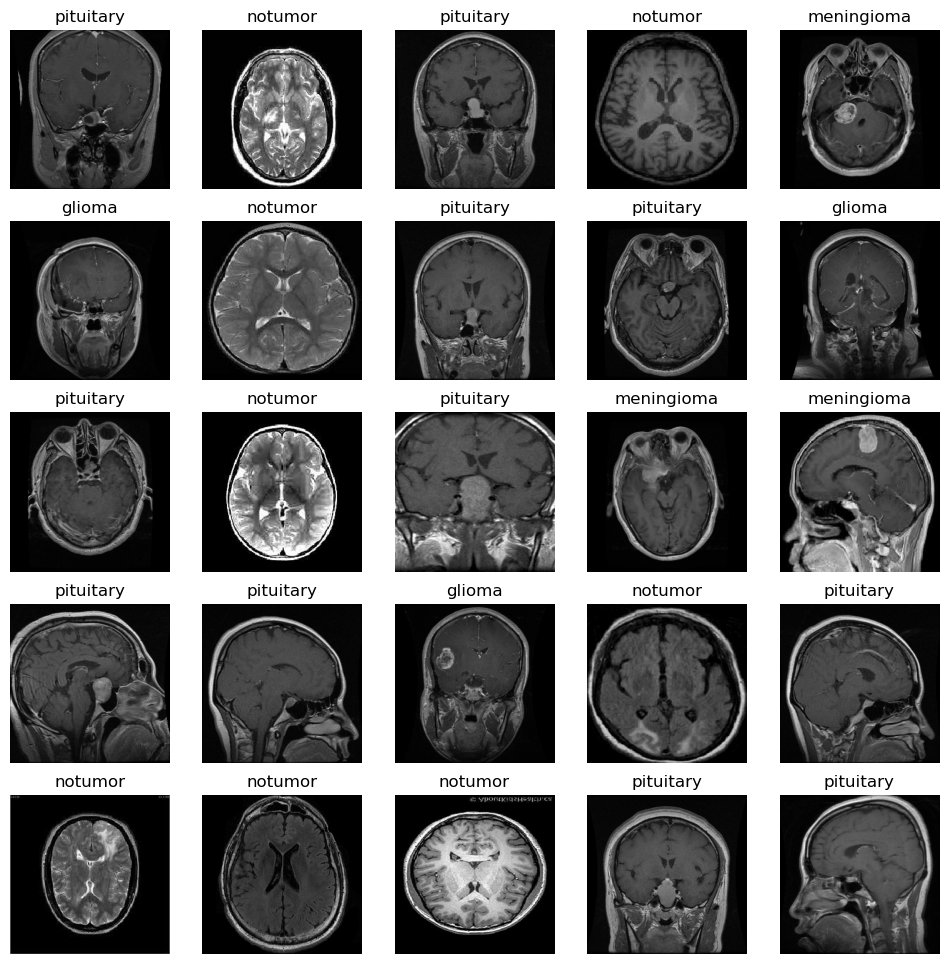

In [6]:
plt.figure(figsize=(12,12))
for img, label in train_set.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[label[i]])
        plt.axis('off')

In [7]:
# prompt: get the number of images based on the class names

import os

image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Training", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 1321
Class: meningioma, Number of images: 1339
Class: notumor, Number of images: 1595
Class: pituitary, Number of images: 1457


In [8]:
image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Testing", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 300
Class: meningioma, Number of images: 306
Class: notumor, Number of images: 405
Class: pituitary, Number of images: 300


In [9]:
# prompt: combine the train and test test into a single varible to store the 7000+ image data with its class

import tensorflow as tf

# Combine the datasets
combined_dataset = train_set.concatenate(test_set)

# You can now iterate through the combined dataset
# Example: Print the shapes of the first batch
for image_batch, label_batch in combined_dataset.take(1):
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", label_batch.shape)

#Further processing or storage of combined_dataset
#Example: Convert to NumPy arrays for easier manipulation if needed
images = []
labels = []

for image_batch, label_batch in combined_dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

#Now images and labels are NumPy arrays containing all the data.
images = np.array(images)
labels = np.array(labels)
print("Total number of Image and labels:",images.shape, labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Total number of Image and labels: (7023, 256, 256, 3) (7023,)


In [10]:
print("Labels and their corresponding numerical values:")
for i, class_name in enumerate(class_names):
  print(f"{i}: {class_name}")

Labels and their corresponding numerical values:
0: glioma
1: meningioma
2: notumor
3: pituitary


In [11]:
# prompt: store the images and labels variable into a single variable called data

data = (images, labels)

In [12]:
images, labels = data

# Create a DataFrame
df = pd.DataFrame({'image': list(images), 'label': list(labels)})

# Print the DataFrame (or perform other operations)
print(df.info()) # Print the first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7023 non-null   object
 1   label   7023 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 82.4+ KB
None


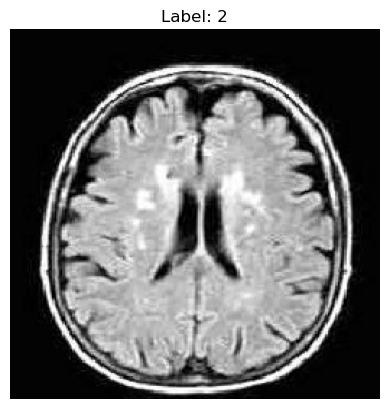

In [13]:
#  view the image that store in the data variable
plt.imshow(data[0][0])  # Access the first image (index 0)
plt.title(f"Label: {data[1][0]}") #Display the label of the first image
plt.axis('off')
plt.show()

In [14]:
input_shape = images.shape[1:]  # Get the shape of your images
num_classes = len(np.unique(labels))  # Get the number of unique classes

print(input_shape)
print(num_classes)

(256, 256, 3)
4


## Simple CNN

In [15]:
# prompt:  use simple cnn to train the model and evaluate the result

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax') # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [16]:
# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set) # Adjust epochs as needed

Epoch 1/10
179/179 [==============================] - 204s 1s/step - loss: 14.5982 - accuracy: 0.7598 - val_loss: 0.4307 - val_accuracy: 0.8291
Epoch 2/10
179/179 [==============================] - 191s 1s/step - loss: 0.2989 - accuracy: 0.8974 - val_loss: 0.4060 - val_accuracy: 0.8764
Epoch 3/10
179/179 [==============================] - 191s 1s/step - loss: 0.1651 - accuracy: 0.9433 - val_loss: 0.2771 - val_accuracy: 0.9100
Epoch 4/10
179/179 [==============================] - 209s 1s/step - loss: 0.0955 - accuracy: 0.9681 - val_loss: 0.2347 - val_accuracy: 0.9176
Epoch 5/10
179/179 [==============================] - 196s 1s/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.2507 - val_accuracy: 0.9298
Epoch 6/10
179/179 [==============================] - 201s 1s/step - loss: 0.0508 - accuracy: 0.9827 - val_loss: 0.3035 - val_accuracy: 0.9321
Epoch 7/10
179/179 [==============================] - 193s 1s/step - loss: 0.0301 - accuracy: 0.9907 - val_loss: 0.2741 - val_accuracy: 0.942

41/41 [==============================] - 11s 272ms/step - loss: 0.2663 - accuracy: 0.9481
Test Loss: 0.2662578523159027
Test Accuracy: 0.9481312036514282


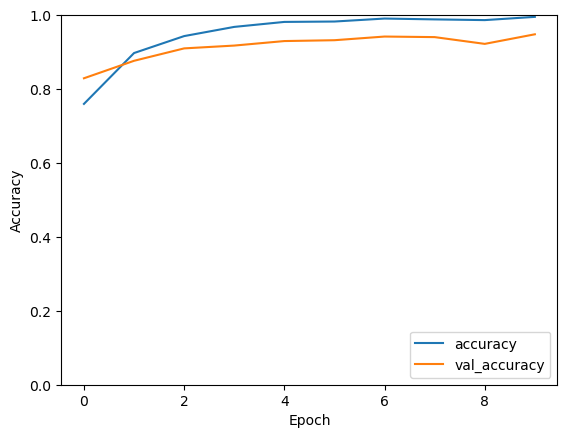

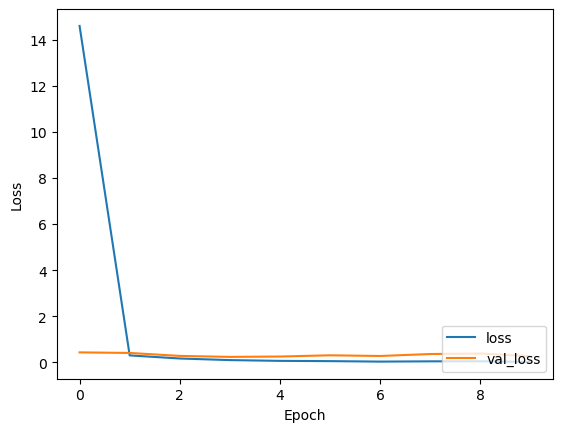

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for images, labels in test_set:
    y_true.extend(labels.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

conf_matrix

41/41 [==============================] - 11s 266ms/step


array([[ 71,  73,  91,  65],
       [ 65,  65,  90,  86],
       [ 94,  74, 131, 106],
       [ 73,  72, 100,  55]], dtype=int64)

In [19]:
# prompt: get classification report

from sklearn.metrics import classification_report

# Get predictions for the test set
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test set
y_true = []
for images, labels in test_set:
    y_true.extend(labels.numpy())

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

41/41 [==============================] - 11s 267ms/step
              precision    recall  f1-score   support

      glioma       0.23      0.23      0.23       300
  meningioma       0.21      0.19      0.20       306
     notumor       0.26      0.26      0.26       405
   pituitary       0.22      0.23      0.22       300

    accuracy                           0.23      1311
   macro avg       0.23      0.23      0.23      1311
weighted avg       0.23      0.23      0.23      1311



## Simple CNN + GoogleNet

In [20]:
# prompt: use googlenet to train the model and evaluate the result

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt

# Load pre-trained InceptionV3 model (excluding the top classification layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the final model
model2 = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [21]:
# Train the model
history2 = model2.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
179/179 [==============================] - 264s 1s/step - loss: 5.9579 - accuracy: 0.6278 - val_loss: 0.7771 - val_accuracy: 0.7674
Epoch 2/10
179/179 [==============================] - 256s 1s/step - loss: 0.7606 - accuracy: 0.7617 - val_loss: 0.8479 - val_accuracy: 0.7590
Epoch 3/10
179/179 [==============================] - 252s 1s/step - loss: 0.6489 - accuracy: 0.7778 - val_loss: 1.9996 - val_accuracy: 0.5576
Epoch 4/10
179/179 [==============================] - 253s 1s/step - loss: 0.6324 - accuracy: 0.7999 - val_loss: 0.9104 - val_accuracy: 0.7399
Epoch 5/10
179/179 [==============================] - 252s 1s/step - loss: 0.4940 - accuracy: 0.8167 - val_loss: 0.4203 - val_accuracy: 0.8459
Epoch 6/10
179/179 [==============================] - 251s 1s/step - loss: 0.4680 - accuracy: 0.8298 - val_loss: 0.4895 - val_accuracy: 0.7963
Epoch 7/10
179/179 [==============================] - 256s 1s/step - loss: 0.3463 - accuracy: 0.8661 - val_loss: 0.4204 - val_accuracy: 0.8520

41/41 [==============================] - 46s 1s/step - loss: 0.4137 - accuracy: 0.8497
Test Loss: 0.4136980473995209
Test Accuracy: 0.8497330546379089


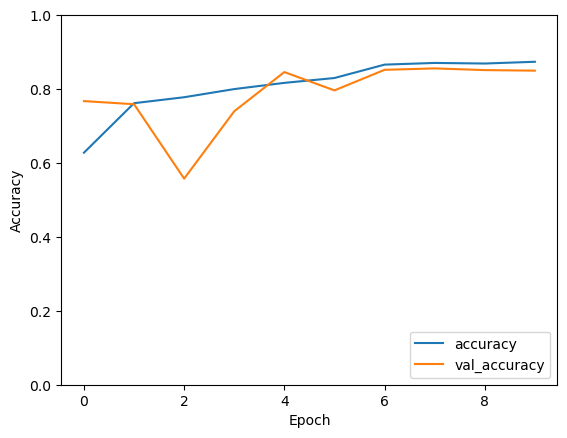

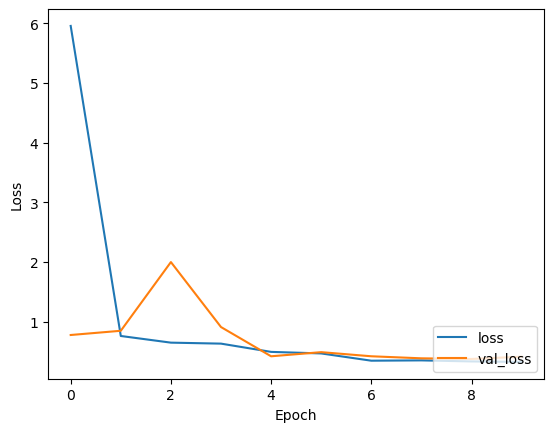

In [22]:
# Evaluate the model
loss2, accuracy2 = model2.evaluate(test_set)
print(f"Test Loss: {loss2}")
print(f"Test Accuracy: {accuracy2}")

# Plot training history (optional)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

## Multiscale CNN

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Multiscale CNN model
input_layer = layers.Input(shape=(256, 256, 3))

# Scale 1: Small-scale features with 3x3 kernels
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

# Scale 2: Larger-scale features with 5x5 kernels
conv2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

# Scale 3: Largest-scale features with 7x7 kernels
conv3 = layers.Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

# Concatenate the outputs of different scales
merged = layers.concatenate([pool1, pool2, pool3])

# Further convolutional layers
conv4 = layers.Conv2D(64, (3, 3), activation='relu')(merged)
pool4 = layers.MaxPooling2D((2, 2))(conv4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu')(pool4)
pool5 = layers.MaxPooling2D((2, 2))(conv5)

# Flatten and Dense layers
flatten = layers.Flatten()(pool5)
dense1 = layers.Dense(128, activation='relu')(flatten)
output = layers.Dense(len(class_names), activation='softmax')(dense1)  # Output layer

# Define the model
multiscale_model = models.Model(inputs=input_layer, outputs=output)

# Compile the model
multiscale_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

multiscale_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_117 (Conv2D)         (None, 256, 256, 32)         896       ['input_7[0][0]']             
                                                                                                  
 conv2d_118 (Conv2D)         (None, 256, 256, 32)         2432      ['input_7[0][0]']             
                                                                                                  
 conv2d_119 (Conv2D)         (None, 256, 256, 32)         4736      ['input_7[0][0]']             
                                                                                            

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
import time

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best weights when stopping
    verbose=1
)

# Set the pause duration (in seconds)
pause_duration = 10  # Pause duration between epochs

# Total epochs
epochs = 10

# Track the stopping condition
stopped_early = False

# Custom training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train for 1 epoch
    history3 = multiscale_model.fit(
        train_set,
        validation_data=test_set,  # Use validation dataset explicitly
        epochs=1,
        verbose=1
    )

    # Check EarlyStopping condition
    if len(history.history['val_loss']) > 1:
        val_loss = history.history['val_loss'][-1]
        prev_val_loss = history.history['val_loss'][0]

        if prev_val_loss <= val_loss:
            early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss})
            if early_stopping.stopped_epoch > 0:
                print("\nEarly stopping triggered.")
                stopped_early = True
                break

    # Pause before the next epoch
    print(f"Pausing for {pause_duration} seconds before the next epoch...")
    time.sleep(pause_duration)

# Final evaluation if training stopped early
if stopped_early:
    print("\nTraining stopped early. Restoring the best weights...")
    multiscale_model.load_weights(early_stopping.best_weights)

# Evaluate the final model
print("\nFinal evaluation on validation set:")
final_eval = multiscale_model.evaluate(test_set, verbose=1)
print(f"Validation Loss: {final_eval[0]:.4f}, Validation Accuracy: {final_eval[1]:.4f}")



Epoch 1/10
179/179 [==============================] - 550s 3s/step - loss: 14.4629 - accuracy: 0.7574 - val_loss: 0.3679 - val_accuracy: 0.8665
Pausing for 10 seconds before the next epoch...

Epoch 2/10
179/179 [==============================] - 560s 3s/step - loss: 0.2283 - accuracy: 0.9244 - val_loss: 0.3234 - val_accuracy: 0.8924
Pausing for 10 seconds before the next epoch...

Epoch 3/10
179/179 [==============================] - 548s 3s/step - loss: 0.1127 - accuracy: 0.9634 - val_loss: 0.2848 - val_accuracy: 0.9268
Pausing for 10 seconds before the next epoch...

Epoch 4/10
179/179 [==============================] - 554s 3s/step - loss: 0.0755 - accuracy: 0.9786 - val_loss: 0.1957 - val_accuracy: 0.9382
Pausing for 10 seconds before the next epoch...

Epoch 5/10
179/179 [==============================] - 544s 3s/step - loss: 0.0349 - accuracy: 0.9898 - val_loss: 0.1741 - val_accuracy: 0.9489
Pausing for 10 seconds before the next epoch...

Epoch 6/10
179/179 [==================

In [37]:
# Evaluate the model
loss3, accuracy3 = multiscale_model.evaluate(test_set)
print(f"Test Loss: {loss3}")
print(f"Test Accuracy: {accuracy3}")

# Plot training history (optional)
plt.plot(history3


.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

41/41 [==============================] - 30s 708ms/step - loss: 0.2501 - accuracy: 0.9519
Test Loss: 0.25010424852371216
Test Accuracy: 0.9519450664520264


TypeError: 'History' object is not subscriptable

## Summary

In [38]:
print("Test Accuracy")
print("Simple CNN:",accuracy)
print("Simple CNN + GoogleNet:",accuracy2)
print("Multiscale CNN",accuracy3)

Test Accuracy
Simple CNN: 0.9481312036514282
Simple CNN + GoogleNet: 0.8497330546379089
Multiscale CNN 0.9519450664520264
